# RNN预测茅台股价

 ## 导入包

In [1]:
# 请输入代码
import pandas as pd
import tushare as ts
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN

## 数据下载

In [2]:
# 获取600519过去十年的数据
df = ts.get_k_data('600519', ktype='D', start='2012-12-10', end='2022-12-10')
# 保存为csv文件
filename = "./SH600519.csv"
df.to_csv(filename)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\Anaconda3\lib\site-packages\tushare\stock\trading.py:708: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\Anaconda3\lib\site-packages\tushare\stock\trading.py:708: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\Anaconda3\lib\site-packages\tushare\stock\trading.py:708: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\Anaconda3\lib\site-packages\tushare\stock\trading.py:708: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\Anaconda3\lib\site-packages\t

 ## 读取数据集

In [3]:
# 读取股票文件
data = pd.read_csv(filename)
data.head()

,Unnamed: 0,date,open,close,high,low,volume,code
0,225,2012-12-11,54.665,57.814,62.516,54.665,92232.0,600519
1,226,2012-12-12,60.037,65.706,65.814,57.971,64325.0,600519
2,227,2012-12-13,64.078,60.615,68.285,60.119,61996.0,600519
3,228,2012-12-14,58.384,62.450,63.756,54.665,78926.0,600519
4,229,2012-12-17,60.863,65.070,67.194,57.557,71361.0,600519


In [4]:
import numpy as np
open_data = np.array(data.iloc[:,2:3])

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(open_data)# .flatten()
def normalize(data):
    data = data/np.max(open_data)
    return data
dataset = dataset.map(normalize)

In [6]:
# 将60天的数据放入一个batch
seq_length = 60
dataset = dataset.batch(seq_length+1, drop_remainder=True)
# 将batch分为模型输入和模型输出
def split_input_target(chunk):
    # 前60天作为输入
    input_text = chunk[:-1]
    # 第61天作为输出
    target_text = chunk[-1]
    return input_text, target_text

dataset = dataset.map(split_input_target)
dataset = dataset.shuffle(10000)

 ## 搭建RNN模型结构


In [7]:
#请输入代码
model = tf.keras.Sequential([
    SimpleRNN(1000, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(1000),
    Dropout(0.2),
    Dense(1)])
model.build(input_shape=(256,60,1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (256, 60, 1000)           1002000   
                                                                 
 dropout (Dropout)           (256, 60, 1000)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (256, 1000)               2001000   
                                                                 
 dropout_1 (Dropout)         (256, 1000)               0         
                                                                 
 dense (Dense)               (256, 1)                  1001      
                                                                 
Total params: 3,004,001
Trainable params: 3,004,001
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='mean_squared_error')  # 损失函数用均方误差

 ## 模型训练


In [9]:
history = model.fit(dataset, batch_size=256, epochs=5, validation_freq=1)

Epoch 1/5
39/39 [==============================] - 3s 29ms/step - loss: 0.0265
Epoch 2/5
39/39 [==============================] - 1s 34ms/step - loss: 0.0042
Epoch 3/5
39/39 [==============================] - 1s 35ms/step - loss: 0.0023
Epoch 4/5
39/39 [==============================] - 1s 35ms/step - loss: 0.0022
Epoch 5/5
39/39 [==============================] - 2s 48ms/step - loss: 0.0026


 ## 损失可视化

No handles with labels found to put in legend.


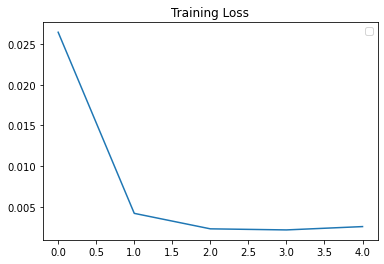

In [10]:
loss = history.history['loss']
plt.plot(loss)
plt.title('Training Loss')
plt.legend()
plt.show()